In [17]:
from astropy.io import fits
import numpy as np
from astropy.visualization import simple_norm
import pylab as plt
from astropy import wcs
import os
from reproject import reproject_interp
import PIL
#import pyavm
import shutil
import itertools
from regions import CircleSkyRegion, PixCoord, CirclePixelRegion, RectanglePixelRegion, EllipseSkyRegion, EllipsePixelRegion, RectangleSkyRegion, RectanglePixelRegion
from matplotlib.colors import LogNorm, PowerNorm, AsinhNorm
import pyavm
from regions import Regions



def save_rgb(img, filename, avm=None, flip=-1):
    img = (img*256)
    img[img<0] = 0
    img[img>255] = 255
    img = img.astype('uint8')
    img = PIL.Image.fromarray(img[::flip,:,:])
    img.save(filename)
    if avm is not None:
        base = os.path.basename(filename)
        dir = os.path.dirname(filename)
        avmname = os.path.join(dir, 'avm_'+base)
        avm.embed(filename, avmname)
        shutil.move(avmname, filename)
    return img



image_filenames_pipe ={
    "f140m": "/orange/adamginsburg/jwst/w51/F140M/pipeline/jw06151-o001_t001_nircam_clear-f140m-merged_i2d.fits",
    "f150w": "/orange/adamginsburg/jwst/w51/F150W/pipeline/jw06151-o001_t001_nircam_clear-f150w-merged_i2d.fits",
    "f182m": "/orange/adamginsburg/jwst/w51/F182M/pipeline/jw06151-o001_t001_nircam_clear-f182m-merged_i2d.fits",
    "f187n": "/orange/adamginsburg/jwst/w51/F187N/pipeline/jw06151-o001_t001_nircam_clear-f187n-merged_i2d.fits",
    "f210m": "/orange/adamginsburg/jwst/w51/F210M/pipeline/jw06151-o001_t001_nircam_clear-f210m-merged_i2d.fits",
    "f335m": "/orange/adamginsburg/jwst/w51/F335M/pipeline/jw06151-o001_t001_nircam_clear-f335m-merged_i2d.fits",
    "f360m": "/orange/adamginsburg/jwst/w51/F360M/pipeline/jw06151-o001_t001_nircam_clear-f360m-merged_i2d.fits",
    "f405n": "/orange/adamginsburg/jwst/w51/F405N/pipeline/jw06151-o001_t001_nircam_clear-f405n-merged_i2d.fits",
    "f410m": "/orange/adamginsburg/jwst/w51/F410M/pipeline/jw06151-o001_t001_nircam_clear-f410m-merged_i2d.fits",
    "f480m": "/orange/adamginsburg/jwst/w51/F480M/pipeline/jw06151-o001_t001_nircam_clear-f480m-merged_i2d.fits",
    'F560W': '/orange/adamginsburg/jwst/w51/F560W/pipeline/jw06151-o002_t001_miri_f560w_i2d.fits',
    'F770W': '/orange/adamginsburg/jwst/w51/F770W/pipeline/jw06151-o002_t001_miri_f770w_i2d.fits',
    'F1000W': '/orange/adamginsburg/jwst/w51/F1000W/pipeline/jw06151-o002_t001_miri_f1000w_i2d.fits',
    'F1280W': '/orange/adamginsburg/jwst/w51/F1280W/pipeline/jw06151-o002_t001_miri_f1280w_i2d.fits',
    'F2100W': '/orange/adamginsburg/jwst/w51/F2100W/pipeline/jw06151-o002_t001_miri_f2100w_i2d.fits'
}

image_sub_filenames_pipe = {
    "f405n-f410m": "/orange/adamginsburg/jwst/w51/filter_subtractions/f405n_minus_f410m.fits",
    "f187n-f182m": "/orange/adamginsburg/jwst/w51/filter_subtractions/f187n_minus_f182m.fits",

}


vmins_pipe = {
    "f140m":-2.126727108957624,
    "f150w":-2.126727108957624,
    "f182m": -2.126727108957624,
    "f187n": -2.126727108957624,
    "f210m": -2.126727108957624,
    "f335m": -2.126727108957624,
    "f360m": -2.126727108957624,
    "f405n": -2.126727108957624,
    "f410m": -2.126727108957624,
    "f480m": -2.126727108957624,
    'F560W': -8.13349615736023,
    'F770W': -13.128868135869467,
    'F1000W': -20.175718796250482,
    'F1280W': -78.54893551563276,
    'F2100W': -401.73422403523676}

vmaxs_pipe = {
    "f140m": 1313.2940185272805,
    "f150w": 2192.119248062432,
    "f182m": 2691.6074981149172,
    "f187n": 10592.668155876943,
    "f210m": 1981.5275413871927,
    "f335m": 3338.1387651409927,
    "f360m": 3661.427520847766,
    "f405n": 16149.326557191509,
    "f410m": 2192.119248062432,
    "f480m": 2192.119248062432,
    'F560W': 2759.232076587026,
    'F770W': 6807.08773003786,
    'F1000W': 7796.714986203987,
    'F1280W': 11822.114404468046,
    'F2100W': 12362.92260996061
}
norms_pipe = {
    "f140m": "sqrt",
    "f150w": "sqrt",
    "f182m": "sqrt",
    "f187n": "sqrt",
    "f210m": "sqrt",
    "f335m": "sqrt",
    "f360m": "sqrt",
    "f405n": "sqrt",
    "f410m": "sqrt",
    "f480m": "sqrt",
    'F560W': 'sqrt',
    'F770W': 'sqrt',
    'F1000W': 'sqrt',
    'F1280W': 'sqrt',
    'F2100W': 'sqrt'
}

basepath = '/orange/adamginsburg/jwst/w51/'


def main(basepath, image_filenames, image_sub_filenames, regfile, 
        vmins_pipe=None, vmaxs_pipe=None, norms_pipe=None,
        image_savepath='/home/t.yoo/w51/w51_jwst_sources_highlight/cutouts/', single_image_cmap = 'inferno',  show=True  ):
    """
    produce single- and three-color images for the region cutouts
    ----------------------------------------------------------------
    Args:
        basepath (str): base path to the JWST data
        image_filenames_pipe (dict): dictionary of image filenames for each filter
        image_sub_filenames_pipe (dict): dictionary of subtracted image filenames
        regfile (str): path to the region file
        vmins_pipe (dict): minimum values for normalization for single color images
        vmaxs_pipe (dict): maximum values for normalization for single color images
        norms_pipe (dict): normalization type for each filter
        image_savepath (str): path to save the images
        single_image_cmap (str): colormap for single color images
    """
    
    label = regfile.split('/')[-1].split('.')[0]

    reg = Regions.read(regfile, format='ds9')[0]
    new_basepath = basepath+'/data_reprojected/'
    if not os.path.exists(new_basepath):
        os.makedirs(new_basepath)
    repr466_image_filenames = {x: y.replace("i2d", "i2d_pipeline_reprj") for x,y in image_filenames.items()}
    repr466_image_filenames = {x: (new_basepath+os.path.basename(y)) for x,y in repr466_image_filenames.items()}
    repr466_image_sub_filenames = {x: y.replace("i2d", "i2d_reprj") for x,y in image_sub_filenames.items()}
    repr466_image_sub_filenames = {x: (new_basepath+os.path.basename(y)) for x,y in repr466_image_sub_filenames.items()}


    tgt_header = fits.getheader(image_filenames_pipe['f405n'], ext=('SCI', 1))
    AVM = pyavm.AVM.from_header(tgt_header)
    print(repr466_image_filenames)

    for filtername in repr466_image_sub_filenames:
        if not os.path.exists(repr466_image_sub_filenames[filtername]):
            print(f"Reprojecting {filtername} {image_sub_filenames[filtername]} to {repr480_image_sub_filenames[filtername]}")
            result,_ = reproject.reproject_interp(image_sub_filenames[filtername], tgt_header, hdu_in='SCI')
            hdu = fits.PrimaryHDU(data=result, header=tgt_header)
            hdu.writeto(repr480_image_sub_filenames[filtername], overwrite=True)
    if isinstance(reg, CircleSkyRegion) or isinstance(reg, EllipseSkyRegion) or isinstance(reg, RectangleSkyRegion):
        pixcoord = reg.to_pixel(wcs.WCS(tgt_header))
        if isinstance(reg, CircleSkyRegion):
            reg = CirclePixelRegion(center=PixCoord(x=pixcoord.center.x, y=pixcoord.center.y), radius=pixcoord.radius)
        elif isinstance(reg, EllipseSkyRegion):
            reg = EllipsePixelRegion(center=PixCoord(x=pixcoord.center.x, y=pixcoord.center.y), width=pixcoord.width, height=pixcoord.height, angle=pixcoord.angle)
        elif isinstance(reg, RectangleSkyRegion):
            reg = RectanglePixelRegion(center=PixCoord(x=pixcoord.center.x, y=pixcoord.center.y), width=pixcoord.width, height=pixcoord.height, angle=pixcoord.angle)
    mask = reg.to_mask()
    
    #make single color images
    for filtername in image_filenames_pipe:
        if not os.path.exists(repr466_image_filenames[filtername]):
            print(f"Reprojecting {filtername} {image_filenames_pipe[filtername]} to {repr466_image_filenames[filtername]}")
            result, _ = reproject_interp(image_filenames_pipe[filtername], tgt_header, hdu_in='SCI')
            hdu = fits.PrimaryHDU(data=result, header=tgt_header)
            hdu.writeto(repr466_image_filenames[filtername], overwrite=True)

        if not os.path.exists(f'{image_savepath}/{label}'):
            os.makedirs(f'{image_savepath}/{label}')
        img = fits.getdata(repr466_image_filenames[filtername])
        img_masked = mask.cutout(img)
        

        fig = plt.figure(figsize=(15,15))
        if norms_pipe is None:
            norm = AsinhNorm(linear_width=1.0)
            plt.imshow(img_masked, origin='lower', cmap=single_image_cmap, norm=norm)
        elif not norms_pipe[filtername] == 'linear':
            if norms_pipe[filtername] == 'log':
           
                norm = LogNorm(vmin=vmins_pipe[filtername], vmax=vmaxs_pipe[filtername])
            elif norms_pipe[filtername] == 'sqrt':
                norm = PowerNorm(gamma=0.5, vmin=vmins_pipe[filtername], vmax=vmaxs_pipe[filtername])
        
            plt.imshow(img_masked, origin='lower', cmap=single_image_cmap, norm=norm)

        else:
            plt.imshow(img_masked, origin='lower', cmap=single_image_cmap, vmin=vmins_pipe[filtername], vmax=vmaxs_pipe[filtername])

      

        plt.savefig(f'{image_savepath}/{label}/{filtername}.png')
        if show:
            plt.show()
        plt.close()


    #make three color images
    comb_list = list(itertools.combinations(image_filenames_pipe.keys(), 3))
    for comb in comb_list:
        rgb = np.array([
            mask.cutout(fits.getdata(repr466_image_filenames[comb[0]])),
            mask.cutout(fits.getdata(repr466_image_filenames[comb[1]])),
            mask.cutout(fits.getdata(repr466_image_filenames[comb[2]]))
        ]).swapaxes(0,2).swapaxes(0,1)

        rgb_scaled = np.array([simple_norm(rgb[:,:,0], stretch='asinh', min_percent=1, max_percent=99)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_percent=1, max_percent=99)(rgb[:,:,1]),
                       simple_norm(rgb[:,:,2], stretch='asinh', min_percent=1, max_percent=99)(rgb[:,:,2])]).swapaxes(0,2).swapaxes(0,1)

        print(rgb_scaled.shape)
        m
        if not os.path.exists(f'{image_savepath}/{label}'):
            os.makedirs(f'{image_savepath}/{label}')
        save_rgb(rgb_scaled, f'{image_savepath}/{label}/rgb_{comb[0]}-{comb[1]}-{comb[2]}.png', avm=AVM)
        fig = plt.figure(figsize=(15,15))
        plt.imshow(rgb_scaled, origin='lower', cmap='inferno')
        plt.close()



Set DATE-AVG to '2025-05-06T13:24:26.757' from MJD-AVG.
Set DATE-END to '2025-05-06T13:48:04.021' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -25.202550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1610191894.941 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


{'f140m': '/orange/adamginsburg/jwst/w51//data_reprojected/jw06151-o001_t001_nircam_clear-f140m-merged_i2d_pipeline_reprj.fits', 'f150w': '/orange/adamginsburg/jwst/w51//data_reprojected/jw06151-o001_t001_nircam_clear-f150w-merged_i2d_pipeline_reprj.fits', 'f182m': '/orange/adamginsburg/jwst/w51//data_reprojected/jw06151-o001_t001_nircam_clear-f182m-merged_i2d_pipeline_reprj.fits', 'f187n': '/orange/adamginsburg/jwst/w51//data_reprojected/jw06151-o001_t001_nircam_clear-f187n-merged_i2d_pipeline_reprj.fits', 'f210m': '/orange/adamginsburg/jwst/w51//data_reprojected/jw06151-o001_t001_nircam_clear-f210m-merged_i2d_pipeline_reprj.fits', 'f335m': '/orange/adamginsburg/jwst/w51//data_reprojected/jw06151-o001_t001_nircam_clear-f335m-merged_i2d_pipeline_reprj.fits', 'f360m': '/orange/adamginsburg/jwst/w51//data_reprojected/jw06151-o001_t001_nircam_clear-f360m-merged_i2d_pipeline_reprj.fits', 'f405n': '/orange/adamginsburg/jwst/w51//data_reprojected/jw06151-o001_t001_nircam_clear-f405n-merged_i

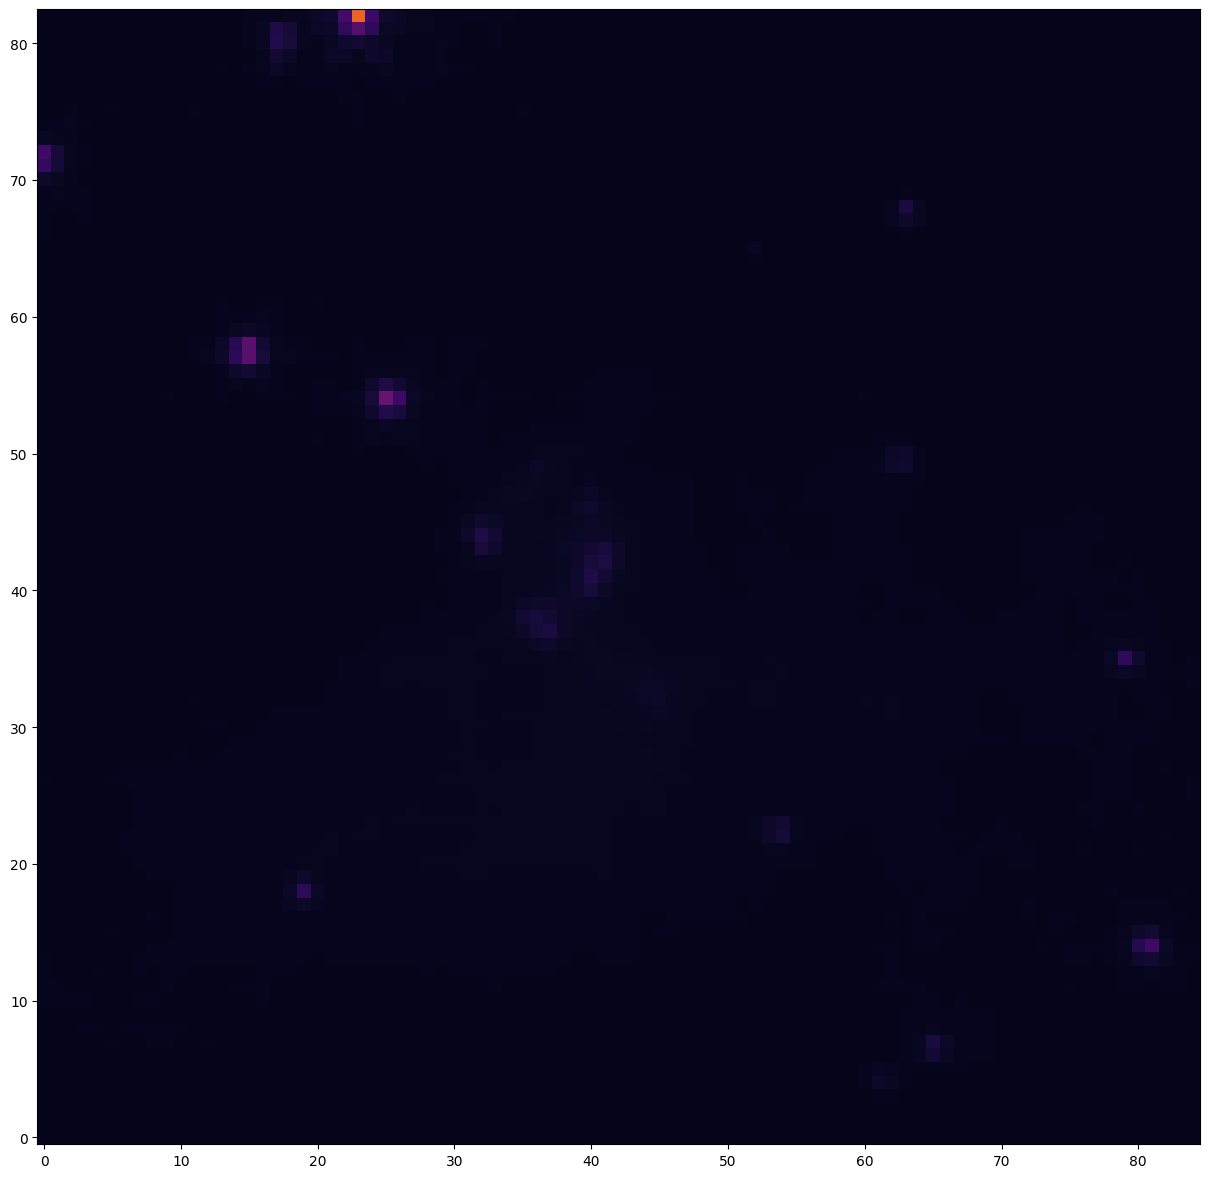

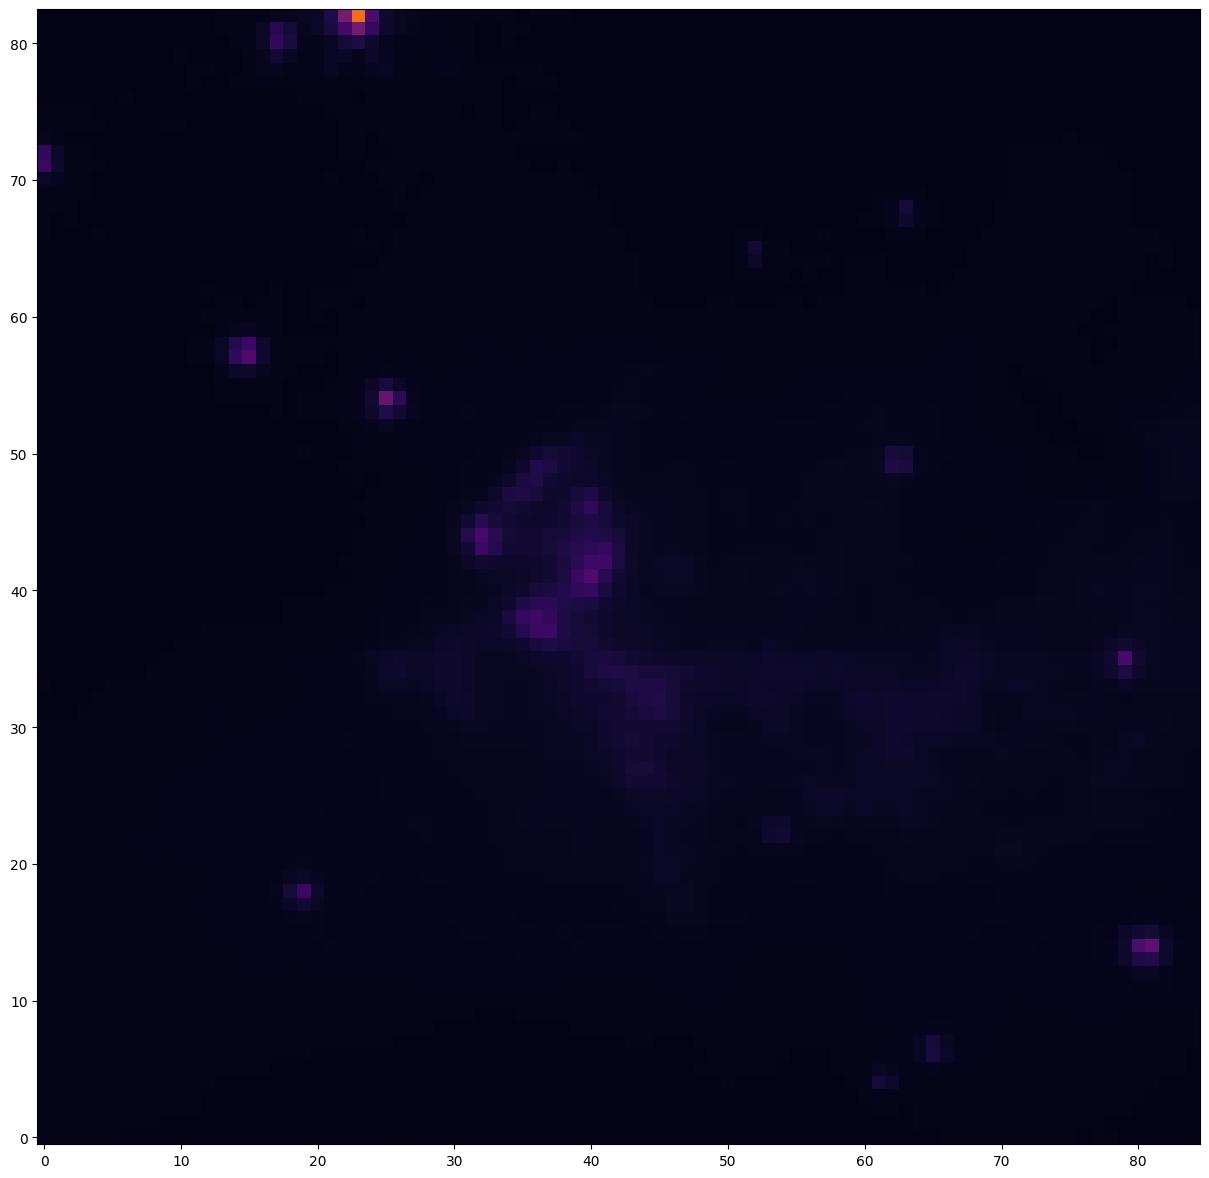

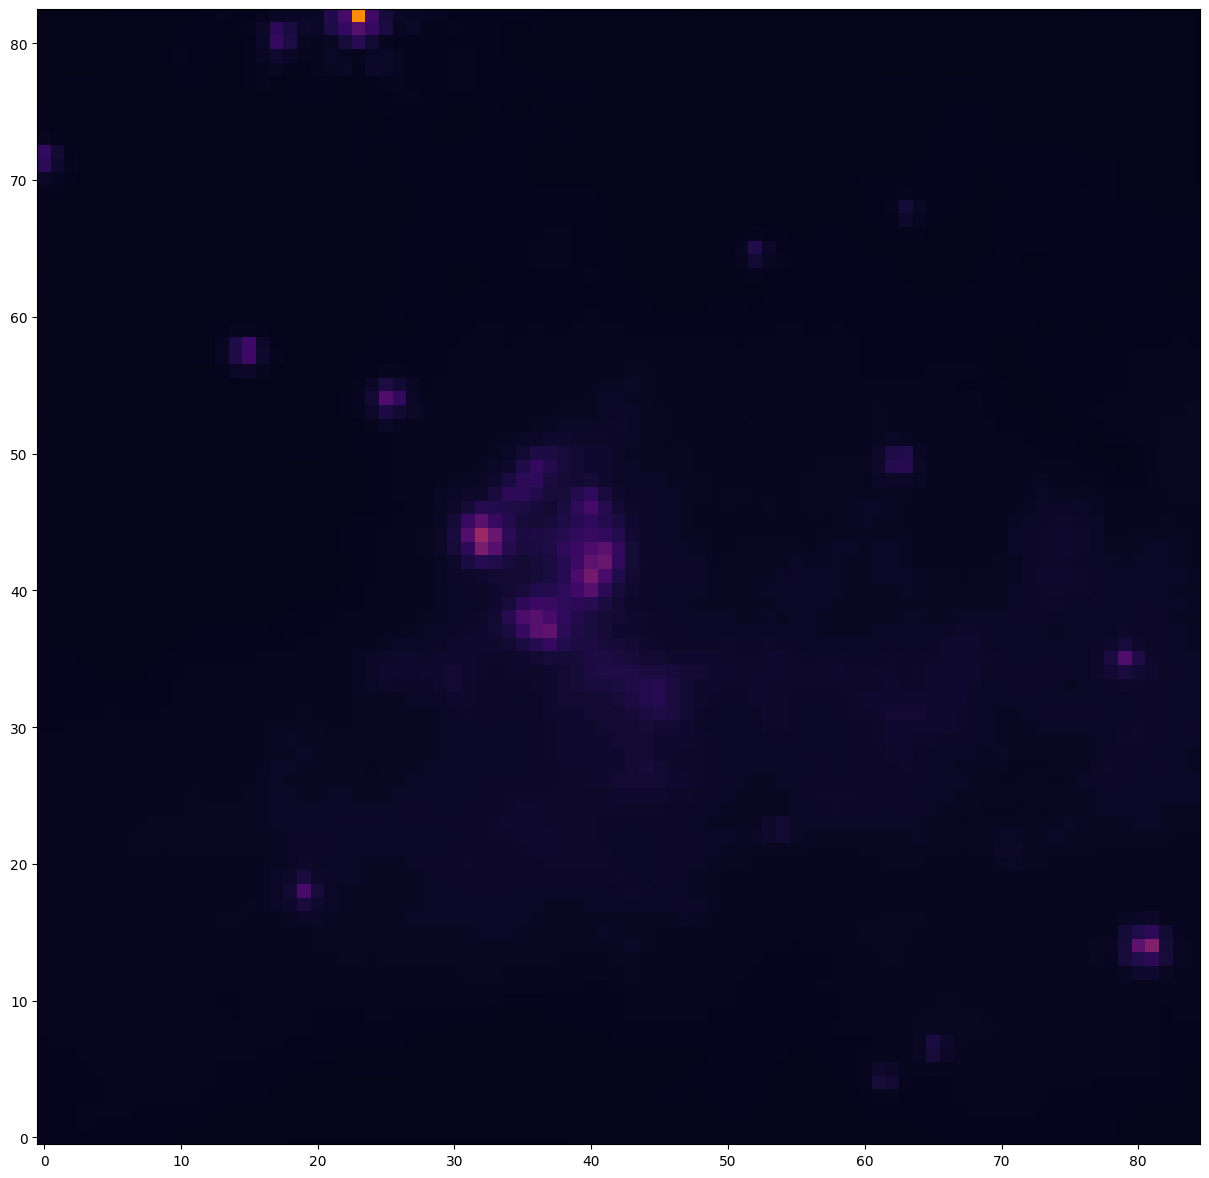

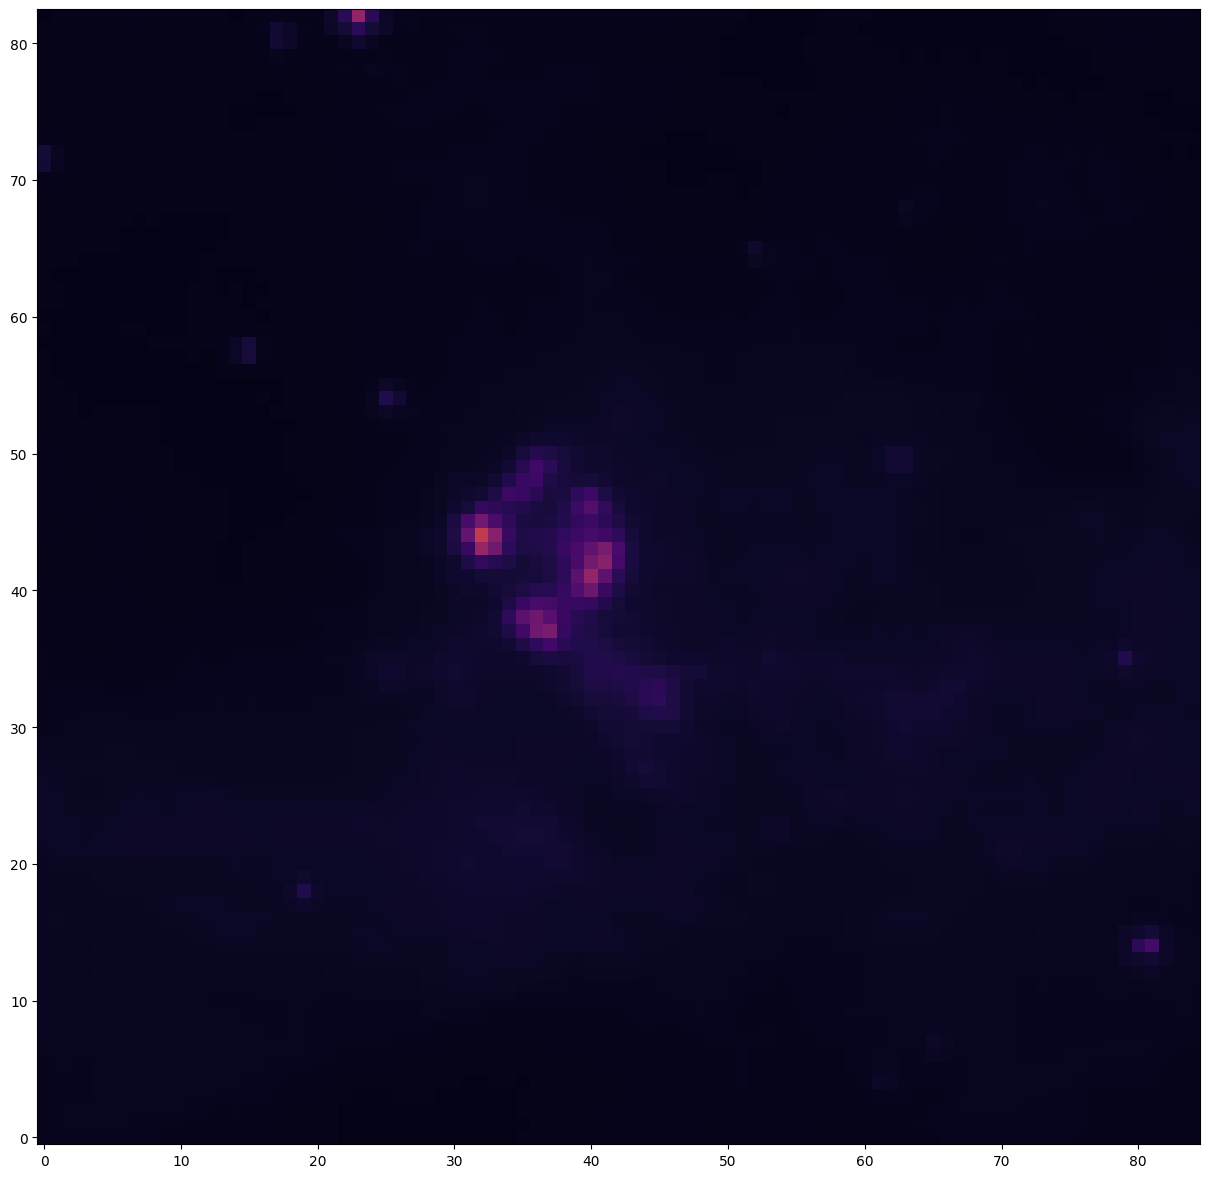

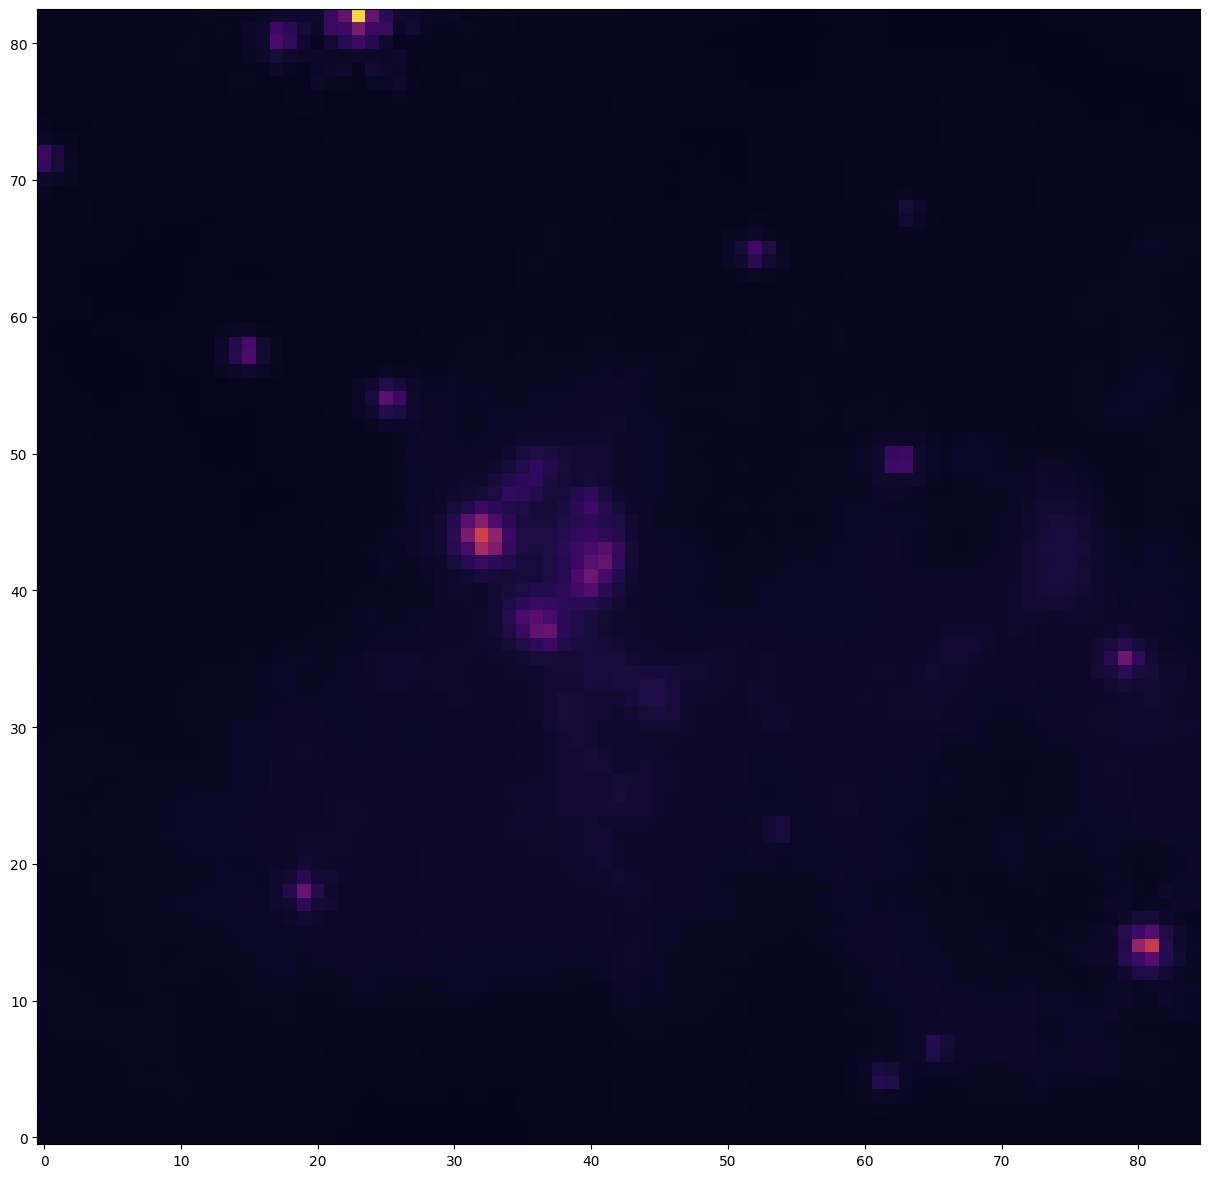

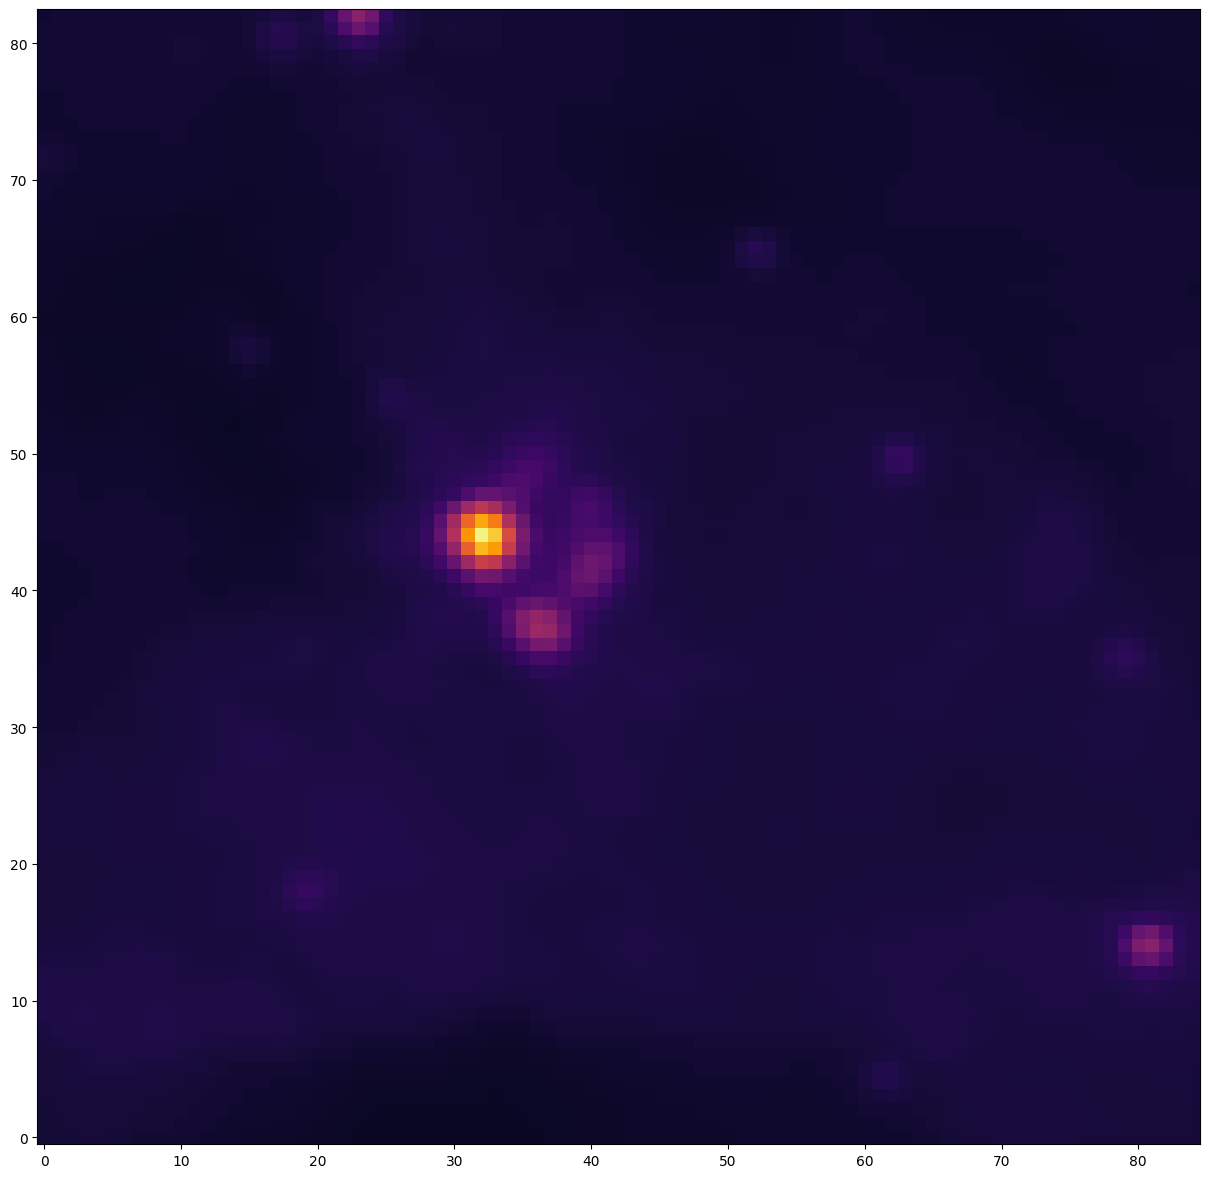

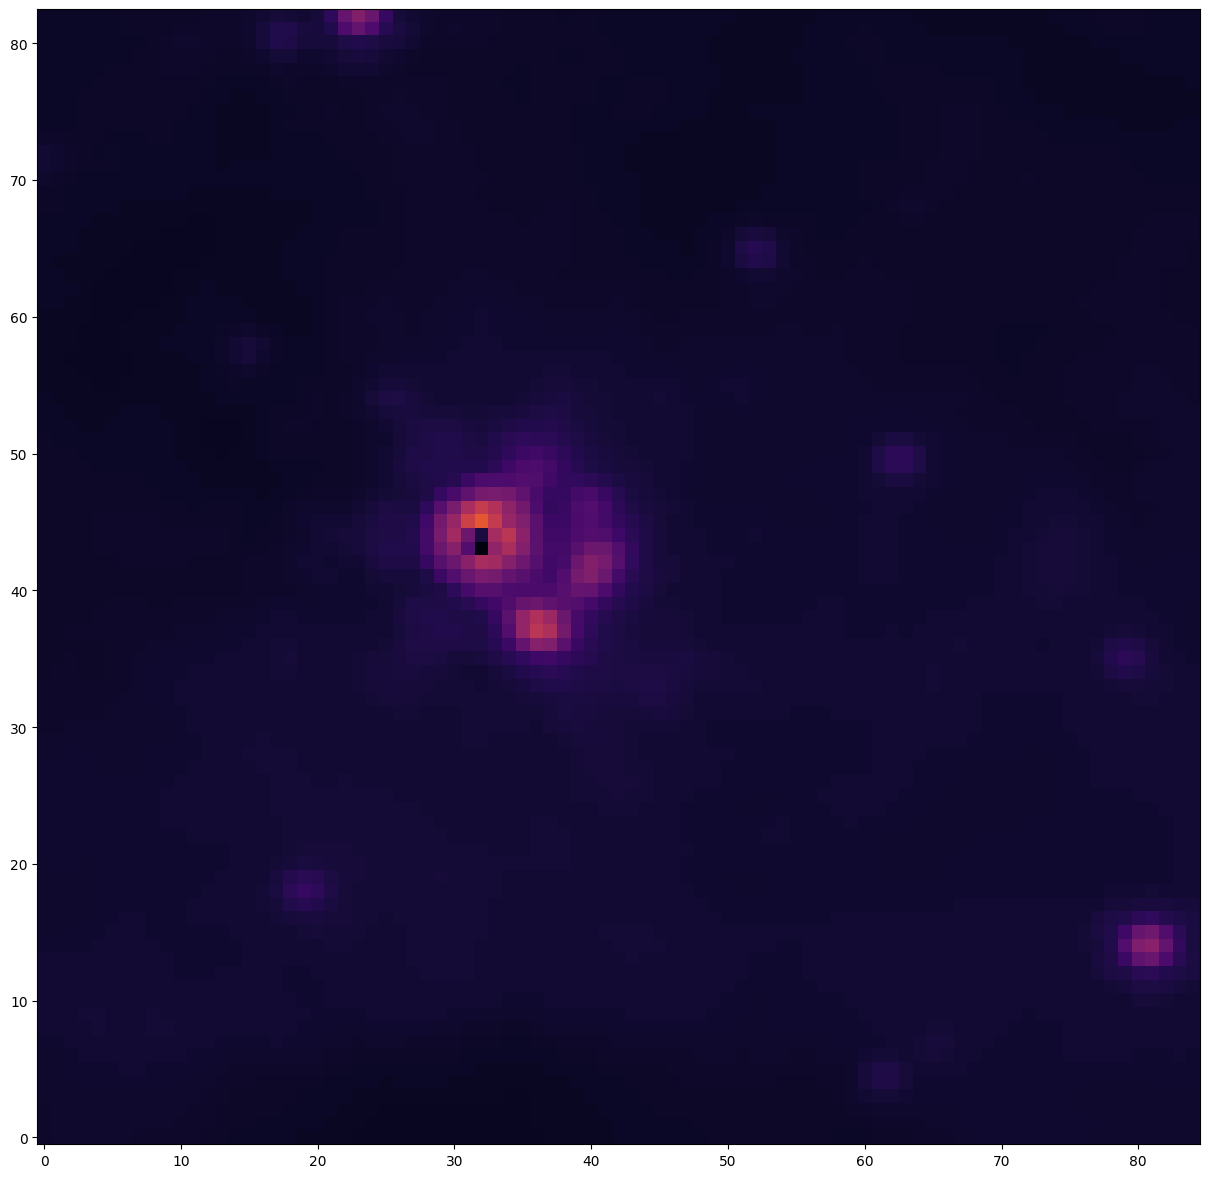

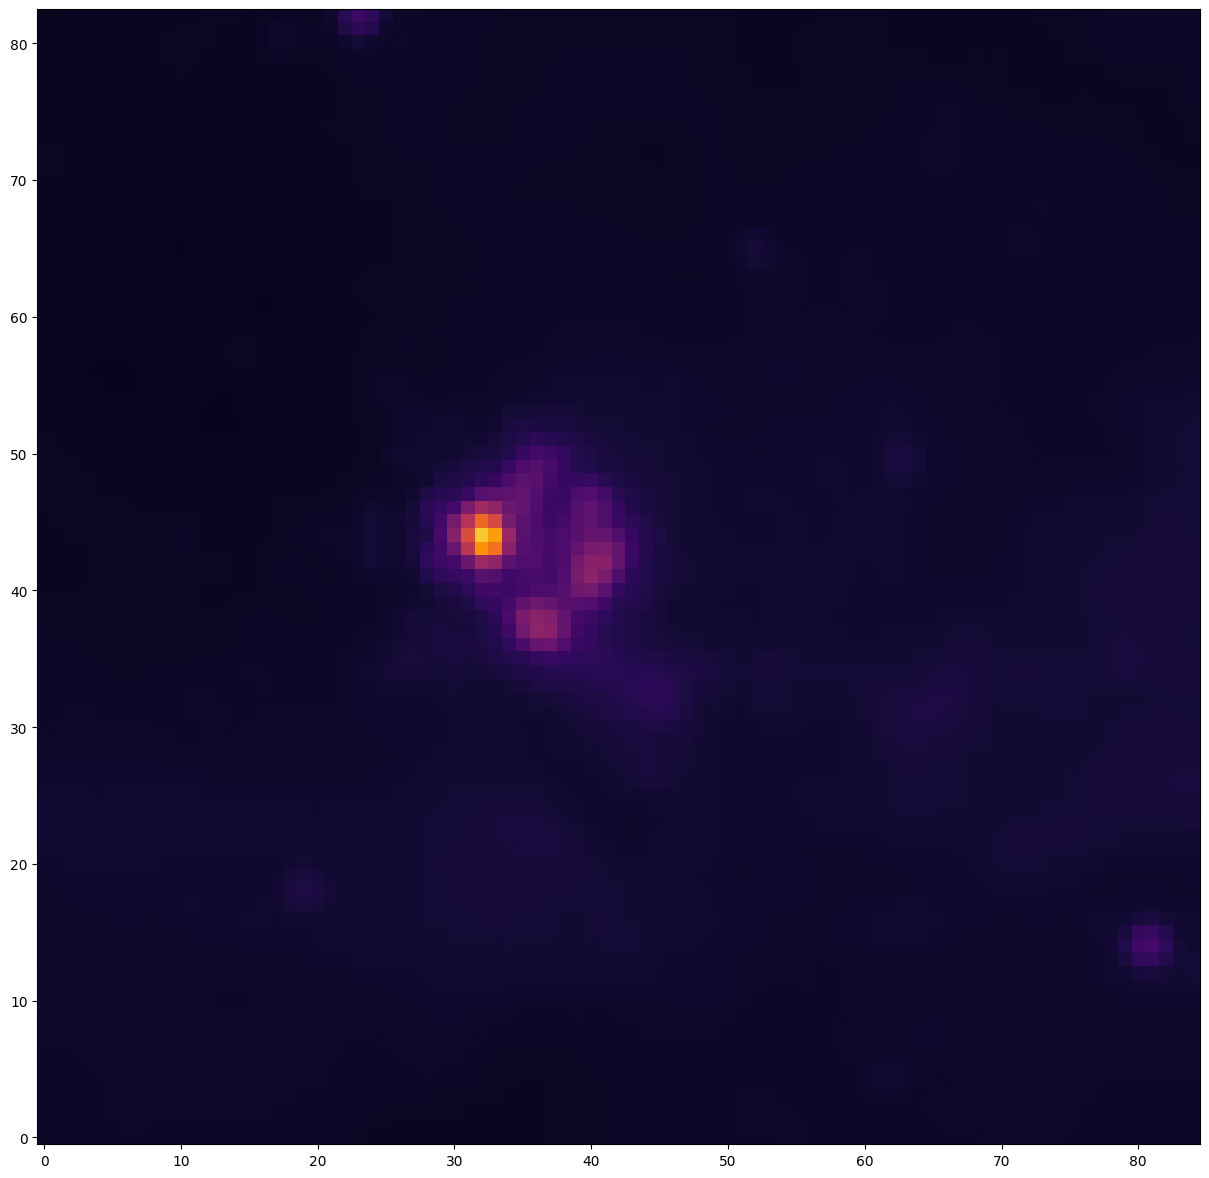

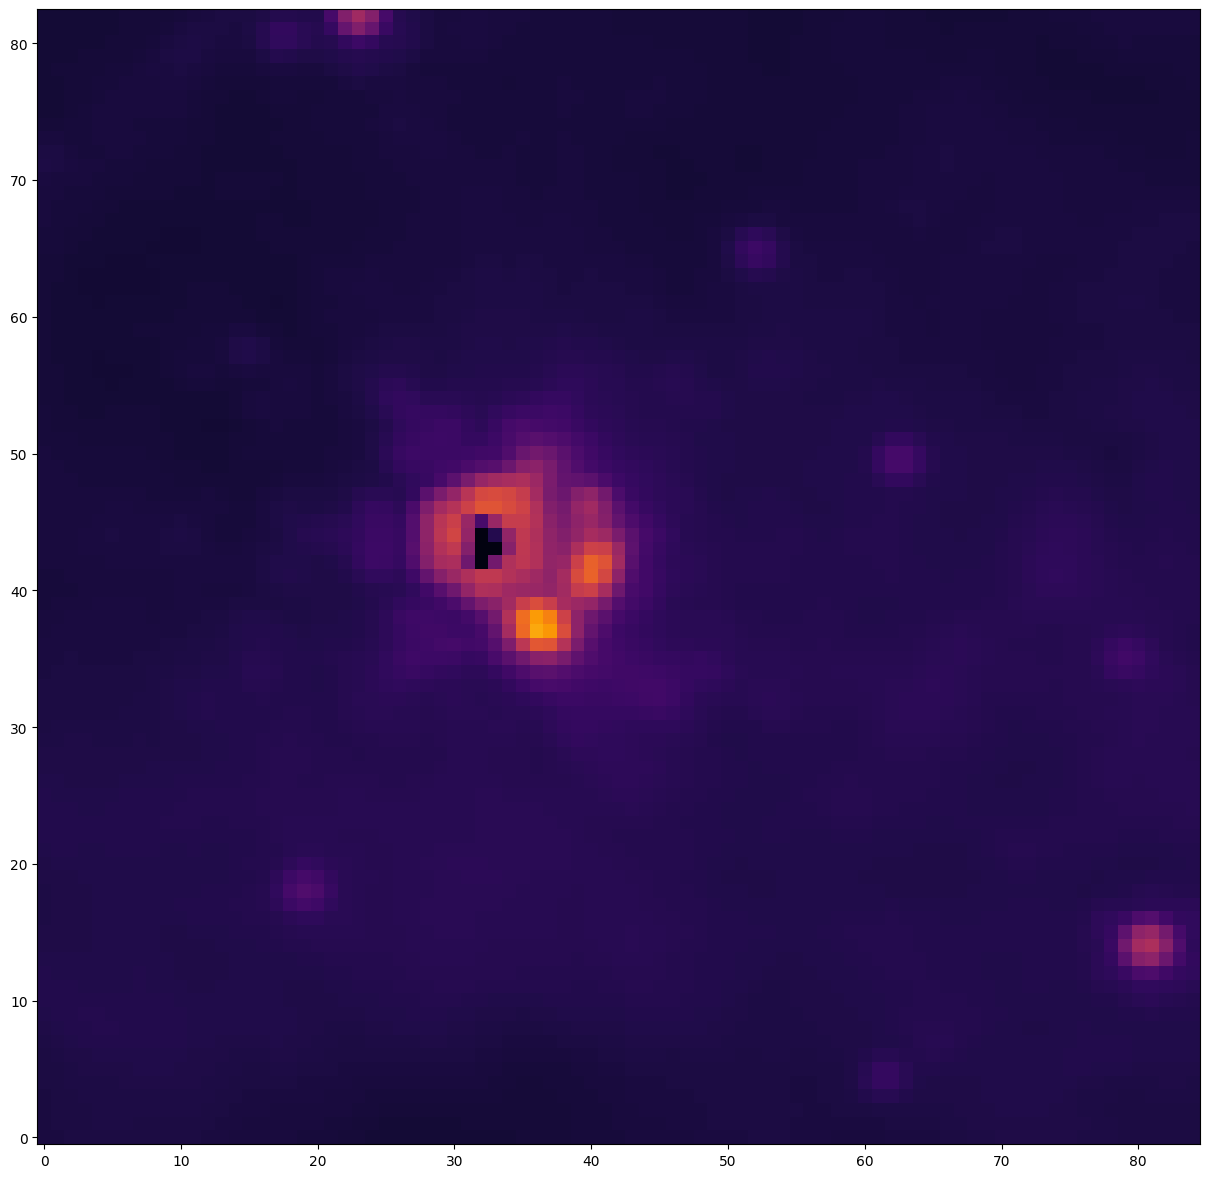

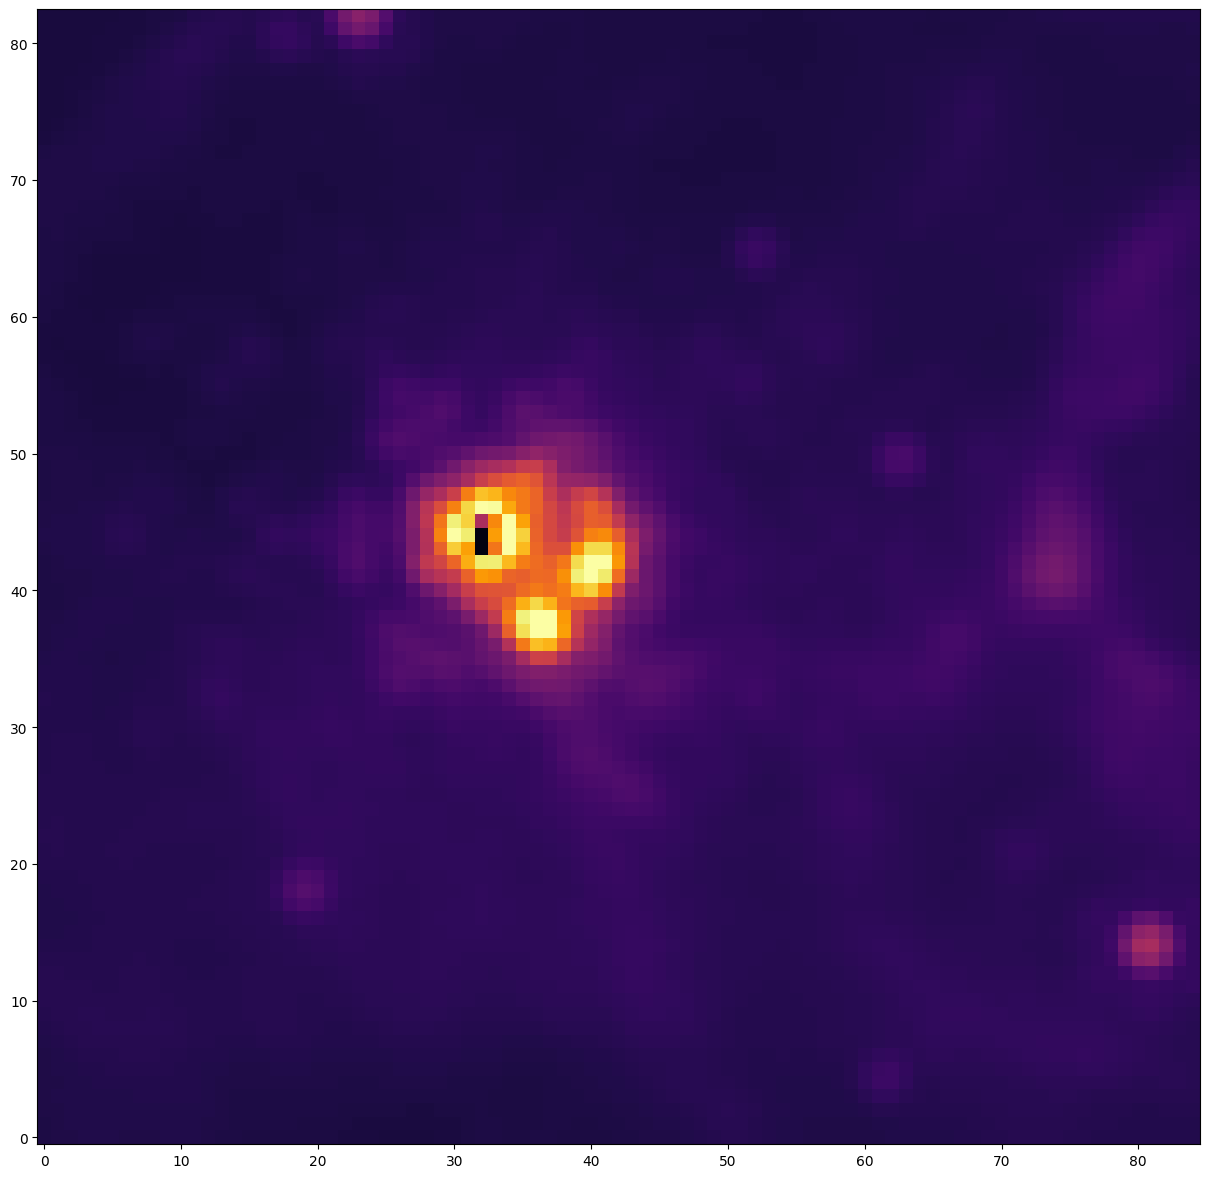

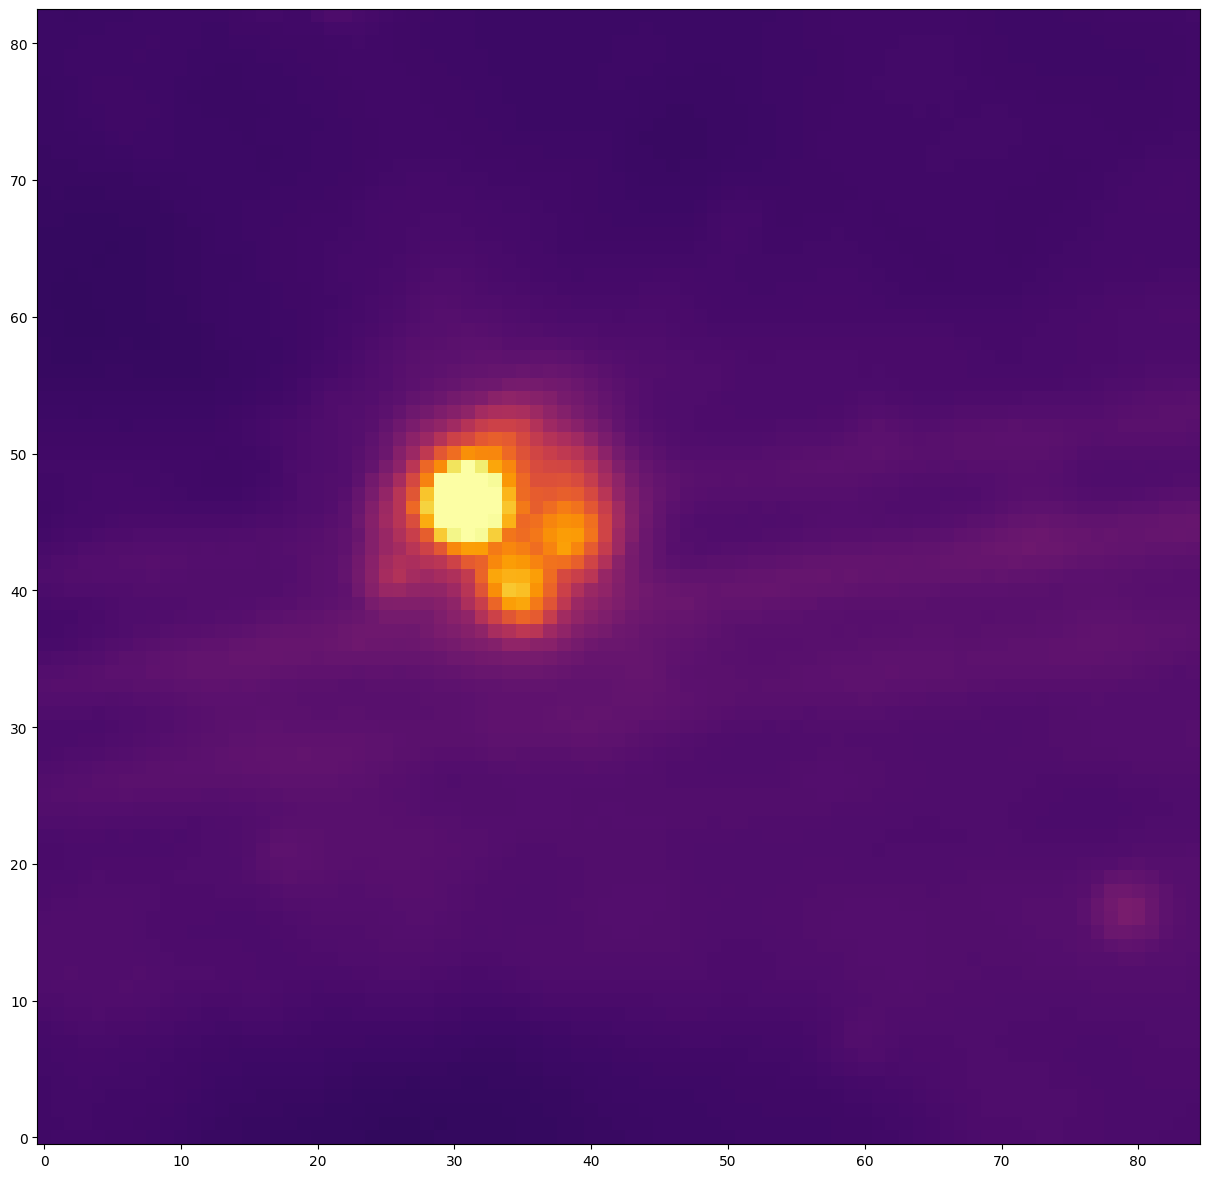

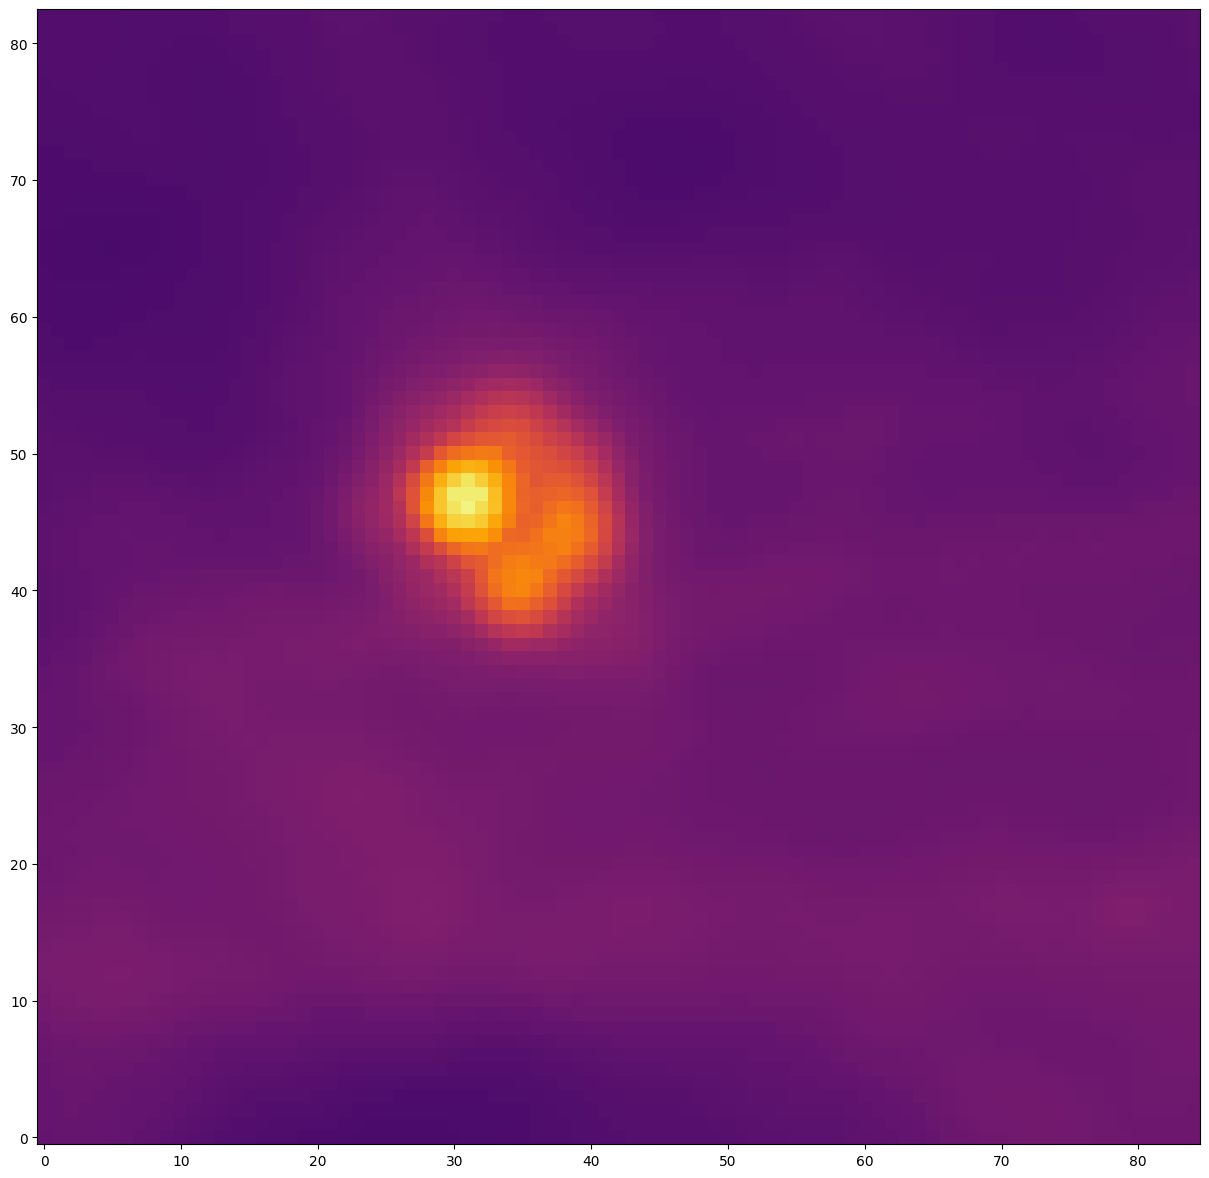

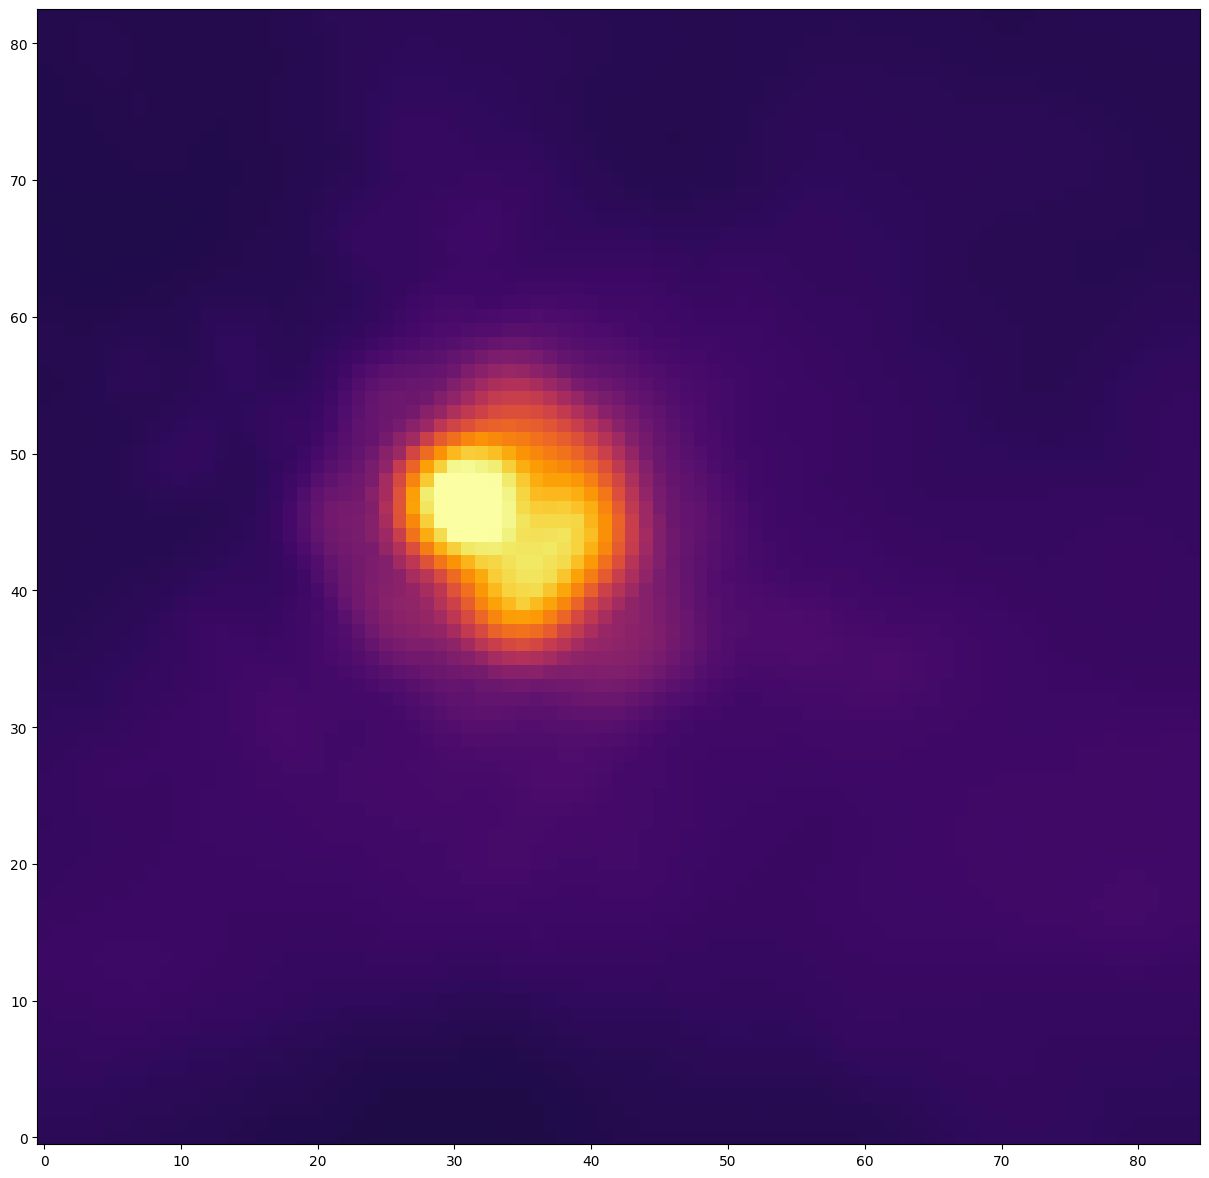

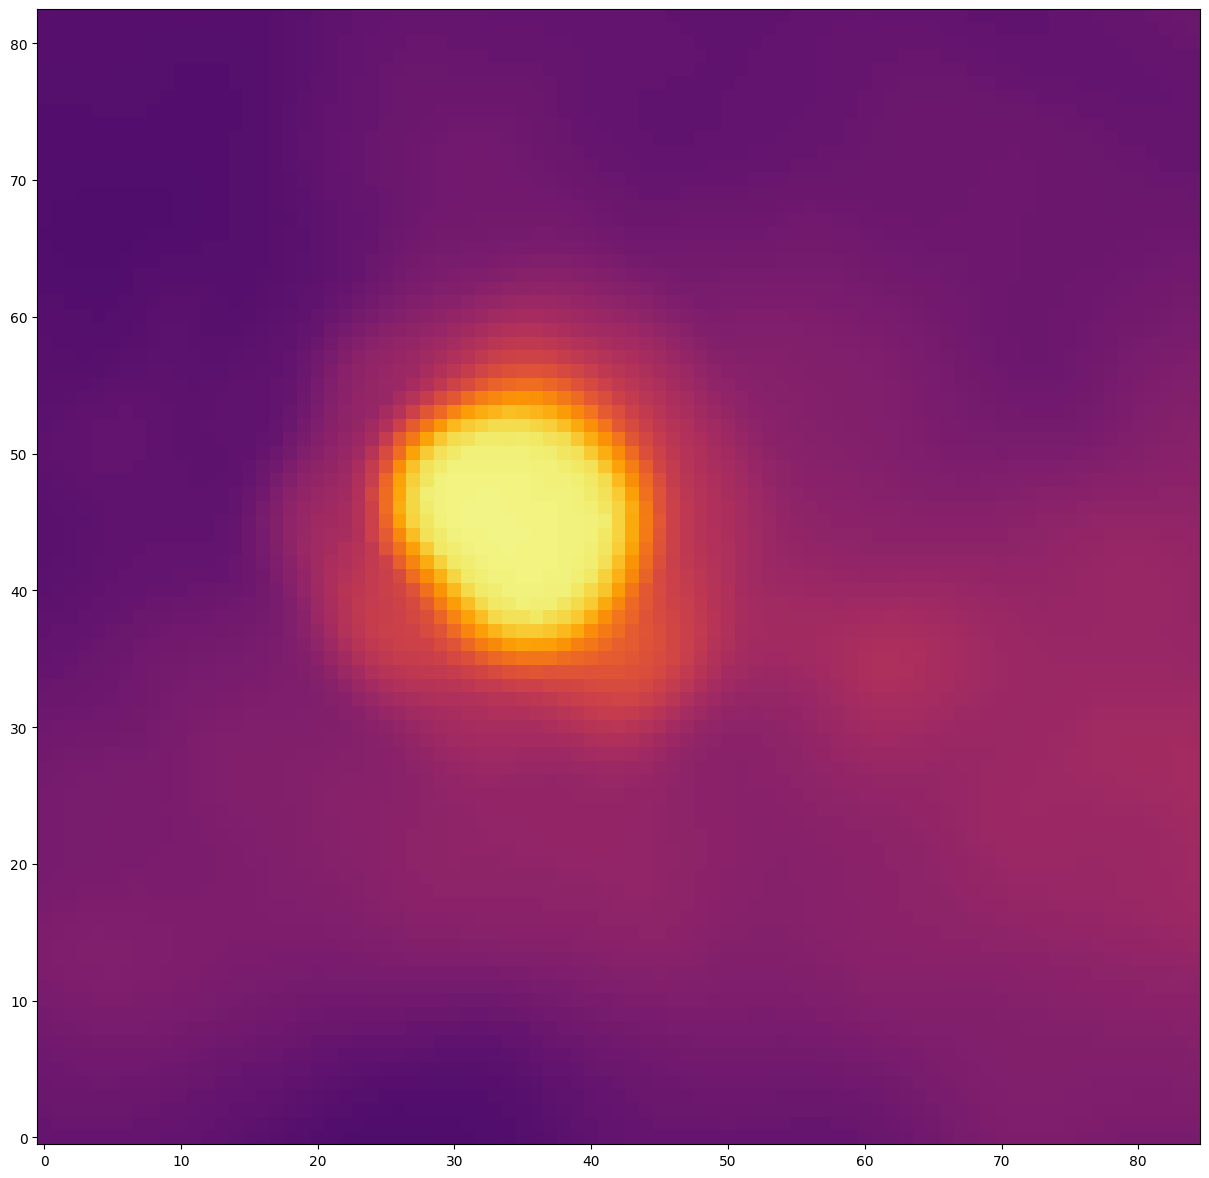

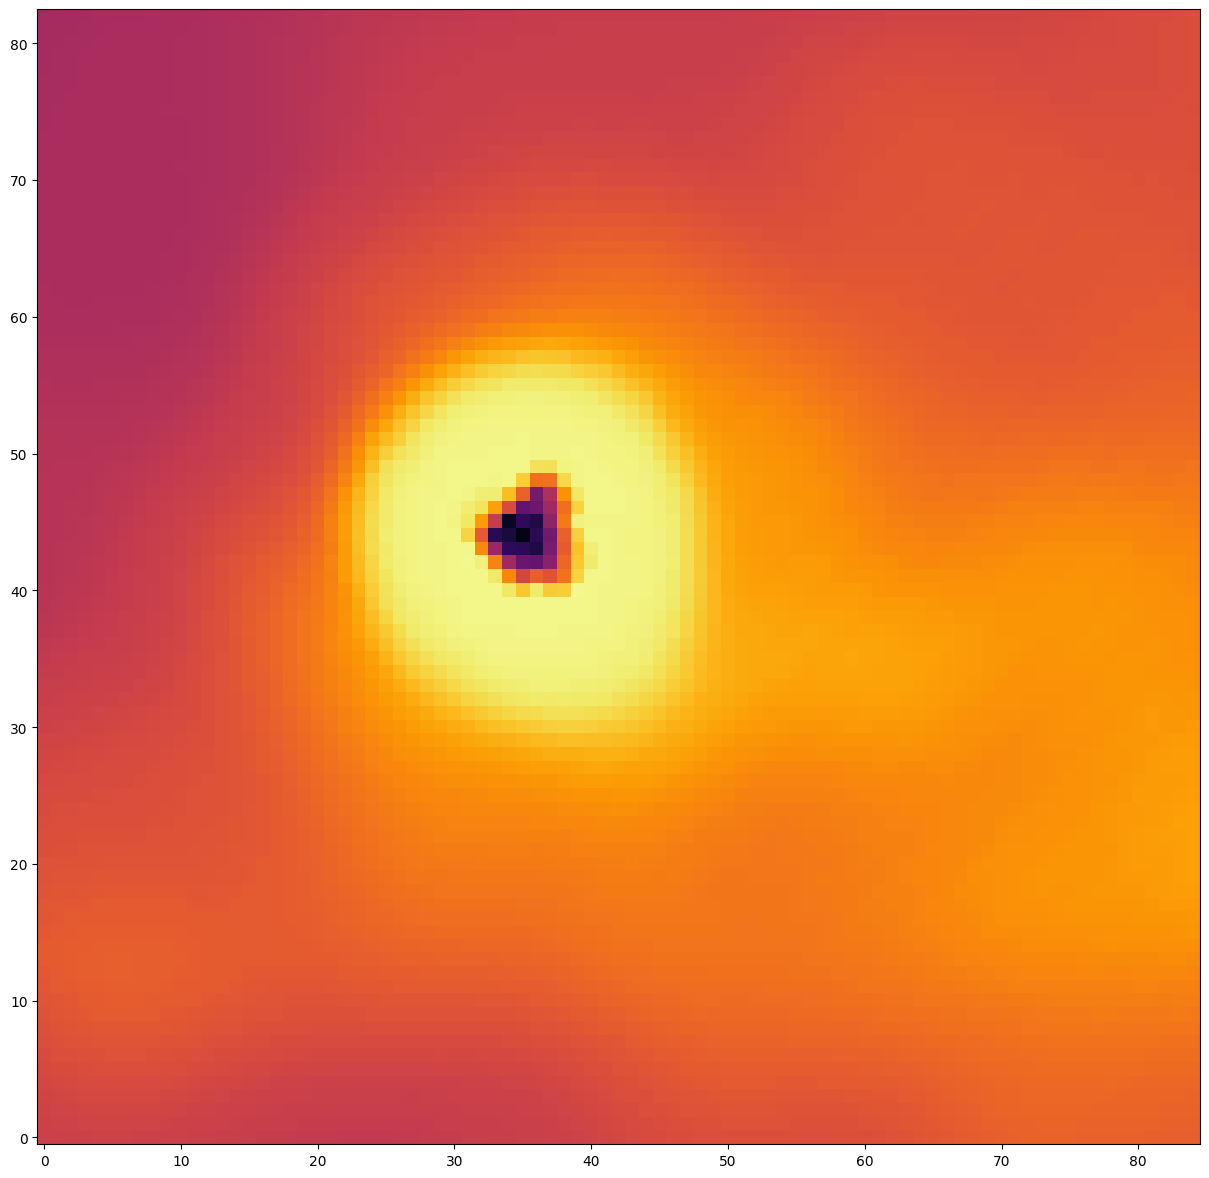

(83, 85, 3)


NameError: name 'm' is not defined

In [18]:
regfile = 'regions/IRS2_outflow.reg'
main(basepath, image_filenames_pipe, image_sub_filenames_pipe, regfile,vmins_pipe=vmins_pipe, vmaxs_pipe=vmaxs_pipe, norms_pipe=norms_pipe,)